# Modelling

## Packages

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt
import pickle 

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.nn import relu, softmax
print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)
    return(smote_x, smote_y)


def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

def under_sample(x,y,same_multiple):
    #undersample = RandomUnderSampler(sampling_strategy='majority')
    print('Before')
    print(y.value_counts())
    count_dict = dict(y.value_counts())
    same_num = min(count_dict['increase'] * same_multiple, count_dict['same'])
    inc_num = count_dict['increase']
    dec_num = count_dict['decrease']

    undersample = RandomUnderSampler(sampling_strategy={'same':same_num, 'decrease':dec_num, 'increase':inc_num})
    x, y = undersample.fit_resample(x, y)
    print('After')
    print(y.value_counts())
    return(x,y)

## Read Data

In [3]:
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'rs', 'lema_diff', 'long_sema_slope']
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'rs']

In [4]:
#train_files = ['2019']
#train_files = ['2016', '2017', '2018', '2019']
train_files = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

df = pd.DataFrame()

for i, train_file in enumerate(train_files): 
    
    train_data = 'data/yearly_tick_data/tab_'+ train_file +'.csv'
    df1 = pd.read_csv(train_data)
    df = df.append(df1)
    df = df.reset_index(drop=True)

df.drop(remove_cols, axis=1, inplace=True)
print(len(df))
df.head(5)

1145209


,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,ema_diff,small_sema_slope,long_sema_slope,slope_diff,direction
0,0.00012,0.00009,0.00001,-0.00003,0.00001,0.00002,0.00009,21.85696,-0.00005,-0.00006,-0.00022,0.00000,-0.00018,-0.00009,-76.22696,-83.75768,7.53073,same
1,0.00013,0.00013,0.00002,-0.00003,-0.00003,0.00002,0.00009,21.47956,0.00002,-0.00006,-0.00014,0.00003,-0.00015,-0.00004,-22.69853,-82.29760,59.59906,same
2,0.00013,0.00016,0.00010,0.00003,0.00022,0.00004,0.00009,29.00339,0.00008,-0.00002,-0.00005,0.00000,-0.00035,0.00002,71.47727,-78.89377,150.37104,increase
3,0.00013,0.00014,0.00011,0.00005,0.00013,0.00004,0.00009,30.94509,0.00010,0.00001,0.00005,0.00000,-0.00035,0.00008,80.37972,-67.57961,147.95933,same
4,0.00012,0.00010,0.00003,0.00002,-0.00010,0.00004,0.00006,38.45511,0.00005,-0.00000,0.00009,0.00010,-0.00025,0.00009,82.18376,0.25964,81.92411,same


In [5]:
%%time
target_col = 'direction'
x = df.loc[:, df.columns != target_col]
y = df[target_col]

#x, y = smote_data(x, y)
#x, y = under_sample(x,y,2)

train_x, valid_x, train_y, valid_y = train_test_split(x, y,train_size = 0.8,random_state = 1)

Wall time: 716 ms


%%time
alg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
clf_xg = GridSearchCV(alg,
                      {'max_depth': [4],
                       'n_estimators': [100],
                       'learning_rate': [0.1]
                      },
                      verbose=2,
                      scoring='neg_log_loss',
                      n_jobs = -1)


clf_xg.fit(train_x, train_y)

print(clf_xg.best_score_, clf_xg.best_params_)

joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

In [6]:
%%time
clf_xg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

clf_xg.fit(train_x, train_y)
filename = 'data/model/xgb.model'
clf_xg.save_model(filename)

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))
print(json.dumps(clf_xg.get_xgb_params(), indent = 2))

[20:16:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.70      0.59      0.64     51619
    increase       0.69      0.59      0.64     51324
        same       0.73      0.82      0.77    126099

    accuracy                           0.72    229042
   macro avg       0.71      0.67      0.68    229042
weighted avg       0.71      0.72      0.71    229042

{
  "objective": "multi:softprob",
  "base_score": 0.5,
  "booster": "gbtree",
  "colsample_bylevel": 1,
  "colsample_bynode": 1,
  "colsample_bytree": 1,
  "gamma": 0,
  "gpu_id": 0,
  "interaction_constraints": "",
  "learning_rate": 0.300000012,
  "max_delta_step": 0,
  "max_depth": 6,
  "min_child_weigh

<AxesSubplot:>

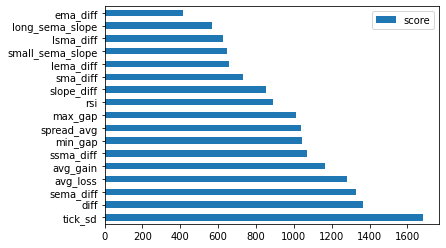

In [8]:
feature_important = clf_xg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

              precision    recall  f1-score   support

    decrease       0.70      0.49      0.58     21180
    increase       0.70      0.48      0.57     21565
        same       0.73      0.87      0.79     66455

    accuracy                           0.72    109200
   macro avg       0.71      0.61      0.65    109200
weighted avg       0.72      0.72      0.71    109200

Wall time: 6.18 s


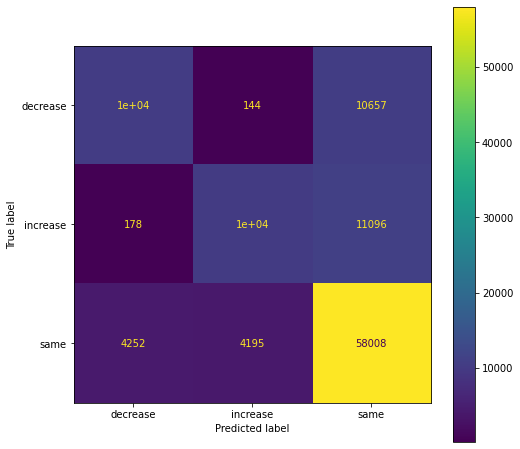

In [11]:
%%time
test_file = '2020'
test_data = 'data/yearly_tick_data/tab_'+ test_file +'.csv'

df1 = pd.read_csv(test_data)
df1 = df1.round(5)
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

loaded_model = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
loaded_model.load_model(filename)

predictions = loaded_model.predict(x)

df1['predictions'] = predictions

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_model.classes_)
disp.plot(ax=ax)

In [12]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)